@author: Pavlo Mospan

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

### All needed imports

In [ ]:
!pip install keras-tuner
!pip install yfinance

import numpy as np
from numpy import concatenate
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout, Activation
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

from tensorflow.keras.models import load_model

import yfinance as yf
from datetime import datetime, date, timedelta

### Data

Time series as (SP500, DXY GOLD) had some missing values (especially on Sundays, as we expected) so I chose to fill those empty values with the nearest value available in the time series. 


In [3]:
today = datetime.today().strftime('%Y-%m-%d')
start_date = '2015-08-07'
idx = pd.date_range(start_date, today)

df_A = yf.download("BTC-USD", start=start_date, end=today)
df_A = df_A["Close"]
df_A = df_A.reindex(idx, fill_value=0, method="nearest")

# The S&P 500 - stock market index that measures the stock performance of 500 large companies listed on stock exchanges in the US. 
df_B = yf.download("%5EGSPC", start=start_date, end=today)
df_B = df_B["Close"]
df_B = df_B.reindex(idx, fill_value=0, method="nearest")

# US Dollar/USDX - Index - Cash
df_C = yf.download("DX-Y.NYB", start=start_date, end=today)
df_C = df_C["Close"]
df_C = df_C.reindex(idx, fill_value=0, method="nearest")

# Gold
df_D = yf.download("GC=F", start=start_date, end=today)
df_D = df_D["Close"]
df_D = df_D.reindex(idx, fill_value=0, method="nearest")

timeseries=  pd.concat([df_A, df_B, df_C, df_D], axis=1)

timeseries.columns=(["Close-btc", "Close-sp500", "Close-dxy", "Close-gold"])
timeseries

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Close-btc,Close-sp500,Close-dxy,Close-gold
2015-08-07,279.584991,2077.570068,97.559998,1094.099976
2015-08-08,260.997009,2077.570068,97.559998,1094.099976
2015-08-09,265.083008,2104.179932,97.160004,1104.199951
2015-08-10,264.470001,2104.179932,97.160004,1104.199951
2015-08-11,270.385986,2084.070068,97.290001,1107.599976
...,...,...,...,...
2021-01-29,34316.386719,3714.239990,90.580002,1847.300049
2021-01-30,34269.523438,3714.239990,90.580002,1847.300049
2021-01-31,33114.359375,3773.860107,91.019997,1860.800049
2021-02-01,33537.175781,3773.860107,91.019997,1860.800049


### Scaling and making Y-column of future Bitcoin values shifted for one day

**Y-column** is *Close-btc-output*

In [4]:
scl = MinMaxScaler()

timeseries[["Close-btc", "Close-sp500", "Close-dxy", "Close-gold"]] = scl.fit_transform(timeseries[
                                                ["Close-btc", "Close-sp500", "Close-dxy", "Close-gold"]])

timeseries["Close-btc-output"] = timeseries["Close-btc"]
timeseries["Close-btc-output"] = timeseries["Close-btc-output"].shift(-1)
#timeseries.drop(timeseries.tail(1).index, inplace=True)
timeseries.loc[today, 'Close-btc-output']
timeseries

,Close-btc,Close-sp500,Close-dxy,Close-gold,Close-btc-output
2015-08-07,0.001702,0.122634,0.610204,0.043270,0.001244
2015-08-08,0.001244,0.122634,0.610204,0.043270,0.001345
2015-08-09,0.001345,0.135766,0.582994,0.053363,0.001330
2015-08-10,0.001330,0.135766,0.582994,0.053363,0.001476
2015-08-11,0.001476,0.125841,0.591837,0.056760,0.001377
...,...,...,...,...,...
2021-01-29,0.840313,0.930355,0.135374,0.795943,0.839159
2021-01-30,0.839159,0.930355,0.135374,0.795943,0.810697
2021-01-31,0.810697,0.959779,0.165306,0.809433,0.821115
2021-02-01,0.821115,0.959779,0.165306,0.809433,0.871178


#### Filling today's **Close-btc-output** value with yesterday value. This is needed for later proper prediction

In [5]:
yesterday = date.today() - timedelta(days=1)
yesterday = yesterday.strftime('%Y-%m-%d')

timeseries.loc[today, 'Close-btc-output'] = timeseries.loc[yesterday, 'Close-btc-output']
timeseries
print(timeseries)
array = timeseries.values
print(array)

            Close-btc  Close-sp500  Close-dxy  Close-gold  Close-btc-output
2015-08-07   0.001702     0.122634   0.610204    0.043270          0.001244
2015-08-08   0.001244     0.122634   0.610204    0.043270          0.001345
2015-08-09   0.001345     0.135766   0.582994    0.053363          0.001330
2015-08-10   0.001330     0.135766   0.582994    0.053363          0.001476
2015-08-11   0.001476     0.125841   0.591837    0.056760          0.001377
...               ...          ...        ...         ...               ...
2021-01-29   0.840313     0.930355   0.135374    0.795943          0.839159
2021-01-30   0.839159     0.930355   0.135374    0.795943          0.810697
2021-01-31   0.810697     0.959779   0.165306    0.809433          0.821115
2021-02-01   0.821115     0.959779   0.165306    0.809433          0.871178
2021-02-02   0.871178     0.959779   0.165306    0.809433          0.871178

[2007 rows x 5 columns]
[[0.00170226 0.12263364 0.61020397 0.04326964 0.00124429]
 [0.0

### Model will be predicting a future Bitcoin values based on three days before

In [6]:
#number of days to take in a row before Y
X_quantity = 3  
mod = len(array) % X_quantity

# how many predictions to make
times = 7

# deleting first-mod values to have /mod-zero array
for i_ in range(mod):
  array = np.delete(array, 0, 0)

# for splitting into train/test
division = X_quantity * times
split = len(array) - division
print('Division: ', division, 'Split is on: ', split)

predict = array[split:]
train = array[:split]

predict, predict.shape

Division:  21 Split is on:  1986


(array([[0.9142277 , 0.97753518, 0.11768727, 0.8022384 , 0.96032531],
        [0.96032531, 0.97047789, 0.11224497, 0.79894078, 0.90213046],
        [0.90213046, 0.95700984, 0.14897971, 0.77795547, 0.88618386],
        [0.88618386, 0.95700984, 0.14897971, 0.77795547, 0.87665218],
        [0.87665218, 0.97214097, 0.12993218, 0.78814829, 0.89731876],
        [0.89731876, 0.97214097, 0.12993218, 0.78814829, 0.88351464],
        [0.88351464, 0.97214097, 0.12993218, 0.78814829, 0.87065207],
        [0.87065207, 0.99826776, 0.12789145, 0.81452984, 0.75430847],
        [0.75430847, 0.99886983, 0.10476193, 0.81393029, 0.80802164],
        [0.80802164, 0.99314501, 0.11224497, 0.80433691, 0.78490792],
        [0.78490792, 0.99314501, 0.11224497, 0.80433691, 0.79037114],
        [0.79037114, 1.        , 0.12244915, 0.80353754, 0.79226863],
        [0.79226863, 1.        , 0.12244915, 0.80353754, 0.79728148],
        [0.79728148, 0.99716723, 0.10748308, 0.7993404 , 0.74462184],
        [0.74462184,

#### Checking if everything is alright and I didn't miss anything

In [7]:
timeseries.tail(21)

,Close-btc,Close-sp500,Close-dxy,Close-gold,Close-btc-output
2021-01-13,0.914228,0.977535,0.117687,0.802238,0.960325
2021-01-14,0.960325,0.970478,0.112245,0.798941,0.902130
2021-01-15,0.902130,0.957010,0.148980,0.777955,0.886184
2021-01-16,0.886184,0.957010,0.148980,0.777955,0.876652
2021-01-17,0.876652,0.972141,0.129932,0.788148,0.897319
2021-01-18,0.897319,0.972141,0.129932,0.788148,0.883515
2021-01-19,0.883515,0.972141,0.129932,0.788148,0.870652
2021-01-20,0.870652,0.998268,0.127891,0.814530,0.754308
2021-01-21,0.754308,0.998870,0.104762,0.813930,0.808022
2021-01-22,0.808022,0.993145,0.112245,0.804337,0.784908


In [9]:
def get_X_values(values):
  """
  Returns numpay.ndarray of sequence of X_quantity days

  Args:
    values: array of predict/train values

  @author: Pavlo Mospan
  """
  x = []
  ready_X = []
  COUNT = 1
  for i_ in values:
    x.extend(i_)
    if COUNT % X_quantity == 0:
      ready_X.append(x)
      x = []

    COUNT += 1

  ready_X = np.array(ready_X)
  return ready_X

def get_Y_targets(targets):
  """
  Returns numpay.ndarray of target values

  Args:
    targets: array of predict/train targets

  @author: Pavlo Mospan
  """
  ready_Y = []
  for i_ in range(int(len(targets) / X_quantity)):
    i_ += 1
    ready_Y.append(targets[i_ * X_quantity -1])

  ready_Y = np.array(ready_Y)
  return ready_Y

In [10]:
# taking 4 features 
predict_values = predict[:, :-1] 
# taking target values
predict_target = predict[:, -1]

print('predict_values.shape: {} | predict_target.shape: {}'.format(predict_values.shape, predict_target.shape))

predict_X = get_X_values(predict_values)
print('\n predict_X type: {} \n predict_X.shape: {} \n predict_X: \n{}'.format(type(predict_X), predict_X.shape, predict_X))

predict_Y = get_Y_targets(predict_target)
print('\nPred Y: {}'.format(predict_Y))

predict_values.shape: (21, 4) | predict_target.shape: (21,)

 predict_X type: <class 'numpy.ndarray'> 
 predict_X.shape: (7, 12) 
 predict_X: 
[[0.9142277  0.97753518 0.11768727 0.8022384  0.96032531 0.97047789
  0.11224497 0.79894078 0.90213046 0.95700984 0.14897971 0.77795547]
 [0.88618386 0.95700984 0.14897971 0.77795547 0.87665218 0.97214097
  0.12993218 0.78814829 0.89731876 0.97214097 0.12993218 0.78814829]
 [0.88351464 0.97214097 0.12993218 0.78814829 0.87065207 0.99826776
  0.12789145 0.81452984 0.75430847 0.99886983 0.10476193 0.81393029]
 [0.80802164 0.99314501 0.11224497 0.80433691 0.78490792 0.99314501
  0.11224497 0.80433691 0.79037114 1.         0.12244915 0.80353754]
 [0.79226863 1.         0.12244915 0.80353754 0.79728148 0.99716723
  0.10748308 0.7993404  0.74462184 0.9483832  0.14013636 0.79354453]
 [0.77460817 0.96645073 0.12721103 0.78654943 0.84031329 0.93035508
  0.13537448 0.79594288 0.83915866 0.93035508 0.13537448 0.79594288]
 [0.81069731 0.95977851 0.16530609 

In [11]:
# taking 4 features
train_values = train[:, :-1]
# taking target values
train_target = train[:, -1]

print('train_values.shape: {} | train_target.shape : {}'.format(train_values.shape, train_target.shape))

train_X = get_X_values(train_values)
print('\n type of train_X: {} \n train_X.shape: {} \n train_X: \n {}'.format(type(train_X), train_X.shape, train_X))

train_Y = get_Y_targets(train_target)
print('\n len(train_Y) : {} '.format(len(train_Y)))

train_values.shape: (1986, 4) | train_target.shape : (1986,)

 type of train_X: <class 'numpy.ndarray'> 
 train_X.shape: (662, 12) 
 train_X: 
 [[0.00170226 0.12263364 0.61020397 ... 0.13576601 0.58299351 0.05336255]
 [0.00132986 0.13576601 0.58299351 ... 0.12681864 0.52176894 0.07234926]
 [0.00132025 0.12550581 0.53469375 ... 0.12952803 0.5428572  0.06205654]
 ...
 [0.78254933 0.92364817 0.08775514 ... 0.9470852  0.06394572 0.85550117]
 [0.96485174 0.97454939 0.08435409 ... 0.98485887 0.1027212  0.78275204]
 [0.93985362 0.97248653 0.13265333 ... 0.9732662  0.09932015 0.79154593]]

 len(train_Y) : 662 


#### Splitting into Train and Test

In [12]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
predict_X = predict_X.reshape((predict_X.shape[0], 1, predict_X.shape[1]))

X_train, X_validate, Y_train, Y_validate = train_test_split(train_X, train_Y, test_size=0.20, random_state=42)

print('X_train.shape: {} |  Y_train: {}'.format( X_train.shape, Y_train.shape))
print('predict_X.shape: {}'.format( predict_X.shape))

X_train.shape: (529, 1, 12) |  Y_train: (529,)
predict_X.shape: (7, 1, 12)


#### Training The Model

keras-tuner is used to get the best possible hyperparameter combination out of 60 different random ones using a random search

*forward_days* is bumber of days to predict

In [14]:
class MyHyperModel(HyperModel):

    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.forward_days = 1 

    def build(self, hp):
        
        # Specify model
        model = Sequential()
        NUM_NEURONS_FirstLayer = hp.Choice('NUM_NEURONS_FirstLayer',values=[80, 90, 100, 120])

        model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=True))

        model.add(Dropout(hp.Float('dropout_1', 0, 0.4, step=0.1, default=0)))

        NUM_NEURONS_SecondLayer = hp.Choice('NUM_NEURONS_SecondLayer',values=[30, 40, 50, 60, 70])
        model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))

        model.add(Dropout(hp.Float('dropout_2', 0, 0.4, step=0.1, default=0)))

        # Output layer
        model.add(Dense(self.forward_days, activation='linear'))

        # Compile the constructed model and return it
        model.compile(
            optimizer=Adam(
                hp.Choice('learning_rate',
                          values=[0.01, 0.001, 0.0001])),
            loss='mean_squared_error')
        print(loss)

        return model

In [15]:
hypermodel = MyHyperModel(num_classes=1)    

# Construct the RandomSearch tuner
random_tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=100,
    executions_per_trial = 1,
    seed=10, 
    project_name='lstm-kerastuner-multi',
    directory="/content")

# Search for the best parameters of the neural network using the contructed random search tuner
random_tuner.search(X_train, Y_train,
             epochs=100,
             validation_data=(X_validate, Y_validate))

#get the best model

random_params = random_tuner.get_best_hyperparameters()[0]
best_model = random_tuner.get_best_models(1)[0]

Trial 100 Complete [00h 00m 14s]
val_loss: 0.00013716610556002706

Best val_loss So Far: 0.00011396520858397707
Total elapsed time: 00h 26m 04s
INFO:tensorflow:Oracle triggered exit


In [16]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 90)             37080     
_________________________________________________________________
dropout (Dropout)            (None, 1, 90)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 70)                45080     
_________________________________________________________________
dropout_1 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 71        
Total params: 82,231
Trainable params: 82,231
Non-trainable params: 0
_________________________________________________________________


#### Saving the model

In [17]:
#Saving the model

file_name = 'LSTM_MULTI-3.h5'
best_model.save(file_name)
print("Saved model `{}` to disk".format(file_name))

Saved model `LSTM_MULTI-3.h5` to disk


#### Loading model fron **/content** or **gdrive** and predicting

In [18]:
# Loading Model

#file_name = '/content/gdrive/MyDrive/ColabData/LSTM_MULTI-3.h5'
file_name = '/content/LSTM_MULTI-3.h5'
model = tf.keras.models.load_model(file_name)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 90)             37080     
_________________________________________________________________
dropout (Dropout)            (None, 1, 90)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 70)                45080     
_________________________________________________________________
dropout_1 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 71        
Total params: 82,231
Trainable params: 82,231
Non-trainable params: 0
_________________________________________________________________


In [19]:
#yhat = best_model.predict(predict_X)       
yhat = model.predict(predict_X) 
yhat, yhat.shape                      

(array([[0.89402366],
        [0.8678383 ],
        [0.7935138 ],
        [0.7786612 ],
        [0.7548254 ],
        [0.8176185 ],
        [0.8325014 ]], dtype=float32), (7, 1))

I have my predicted values and target values. Now I need only to reshape them and do inverse transform on them 

In [20]:
def get_array(g):
  """
  Gets an array of type (None, 1), shapes it into the shape (None, 4), then scales and returns only predicted values
  
  :param: array of shape (None, 1)
  :return: array ready for predictions with shape (None, 4)

  @author: Pavlo Mospan
  """
  g = np.insert(g, [1], .4, axis = 1)
  g = np.insert(g, [2], .4, axis = 1)
  g = np.insert(g, [3], .4, axis = 1)

  array_ = scl.inverse_transform(g)
  array_ready = []
  for i in range(len(array_[:, :1])):
    array_ready.append(array_[i,:1][0])

  return array_ready

### Predicting on Test Set

In [21]:
pred = get_array(yhat)
print("PRED: ", pred)

true = get_array(predict_Y.reshape(-1,1))
print('TRUE: ', true)

PRED:  [36496.336, 35433.547, 32416.93, 31814.105, 30846.682, 33395.27, 33999.324]
TRUE:  [36178.140625, 36069.8046875, 33005.76171875, 32366.392578125, 31649.605468750004, 33114.359375, 35569.078125]


### Dataframe of predicted values on theit true ones. Note, that the last value in true column doesn't count, since it was added to target array purely to make prediction - it's not real and does not exist. 

In [22]:
d = {"pred": pred, "true": true}
df = pd.DataFrame(d)
df

,pred,true
0,36496.335938,36178.140625
1,35433.546875,36069.804688
2,32416.929688,33005.761719
3,31814.105469,32366.392578
4,30846.681641,31649.605469
5,33395.269531,33114.359375
6,33999.324219,35569.078125


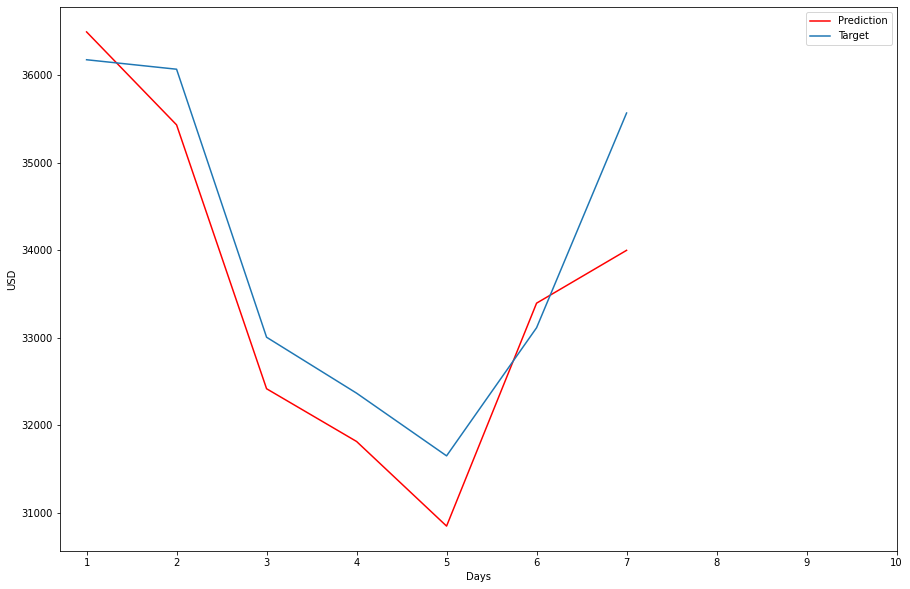

In [23]:
plt.figure(figsize = (15,10))
plt.plot(pred, color='r', label='Prediction') 
plt.plot(true, label='Target')
plt.xticks(np.arange(0, 10, 1), np.arange(1, 21, 1))
plt.xlabel('Days')
plt.ylabel('USD')
plt.legend(loc='best')
plt.show()

### Predicting on All Values


1.   Retrieving all values
2.   Reshaping them to match model.predict() conditions
3.   Predicting
4.   Plotting predictions



In [24]:
predict_all = get_X_values(array[:,:-1])
predict_all.shape

(669, 12)

In [25]:
predict_all = predict_all.reshape((predict_all.shape[0], 1, predict_all.shape[1]))
predict_all.shape

(669, 1, 12)

In [26]:
yhat = model.predict(predict_all) 
    
pred = get_array(yhat)
yhat.shape , len(pred)

((669, 1), 669)

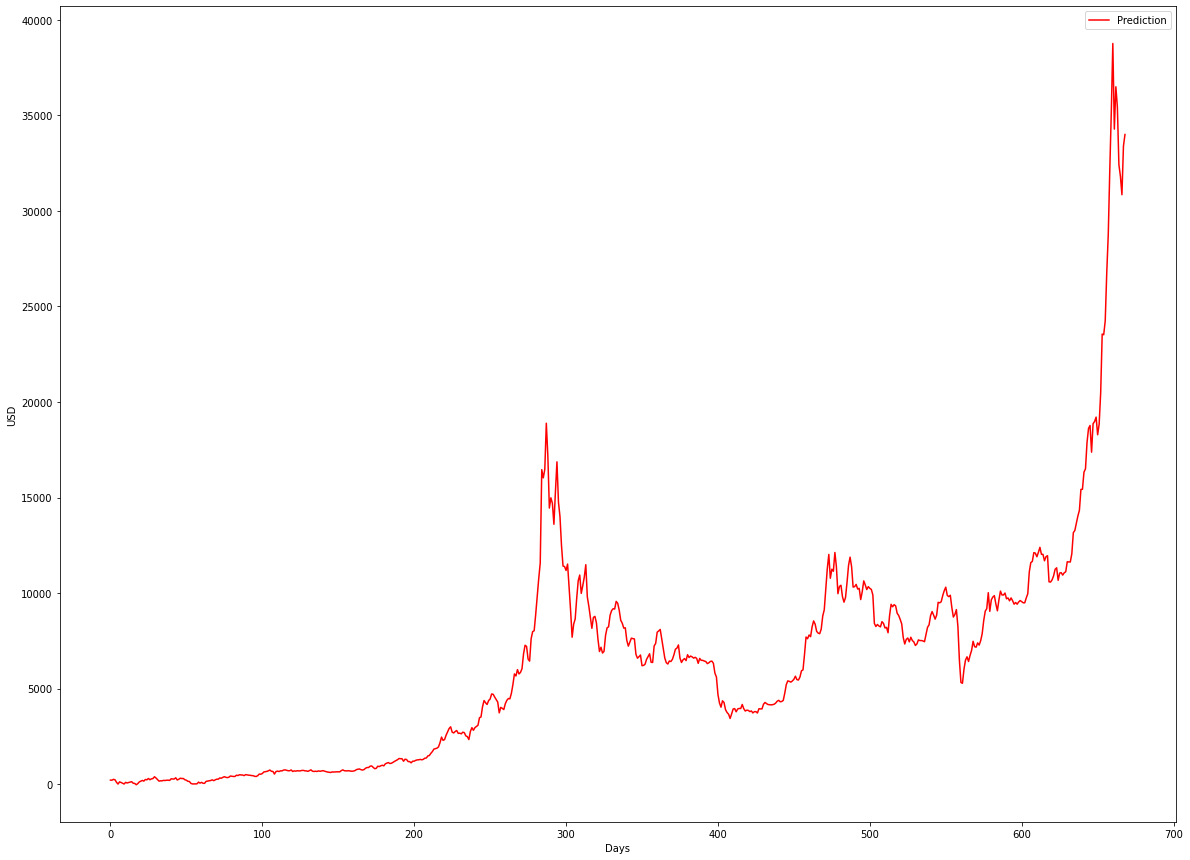

In [27]:
plt.figure(figsize = (20,15))
plt.plot(pred, color='r', label='Prediction') 

#plt.xticks(np.arange(0, 10, 1), np.arange(1, 21, 1))
plt.xlabel('Days')
plt.ylabel('USD')
plt.legend(loc='best')
plt.show()

### Retrieving timestamp of each prediction and concatenating it with prediction values.

Reminder: each prediction in array *pred* is made on the basis of three days before. For instance, predicted value for timestep 2015-08-10 is based on 7th, 8th and 9th days

In [28]:
t = timeseries.reset_index()
timestamp = pd.DataFrame()
timestamp['data'] = t['index'].copy()
timestamp

,data
0,2015-08-07
1,2015-08-08
2,2015-08-09
3,2015-08-10
4,2015-08-11
...,...
2002,2021-01-29
2003,2021-01-30
2004,2021-01-31
2005,2021-02-01


In [29]:
DAY = 0
ds = []
tomorrow = date.today() + timedelta(days=1)
tomorrow = tomorrow.strftime('%Y-%m-%d')

for i_ in range(len(pred)):
  if i_ == (len(pred) -1):
    ds.append(tomorrow)
  else:
    DAY = DAY + 3
    ds.append(timestamp.iloc[DAY][0].strftime('%Y-%m-%d'))

len(ds)

669

In [30]:
d = {"ds": ds, "pred": pred}
df = pd.DataFrame(d)
df

,ds,pred
0,2015-08-10,209.157486
1,2015-08-13,206.991119
2,2015-08-16,250.022293
3,2015-08-19,228.031036
4,2015-08-22,95.495018
...,...,...
664,2021-01-22,32416.929688
665,2021-01-25,31814.103516
666,2021-01-28,30846.677734
667,2021-01-31,33395.269531
